# MNIST Code Along with CNN
Now that we've seen the results of an artificial neural network model on the <a href='https://en.wikipedia.org/wiki/MNIST_database'>MNIST dataset</a>, let's work the same data with a <a href='https://en.wikipedia.org/wiki/Convolutional_neural_network'>Convolutional Neural Network</a> (CNN).
Make sure to watch the theory lectures! You'll want to be comfortable with:
* convolutional layers
* filters/kernels
* pooling
* depth, stride and zero-padding

Note that in this exercise there is no need to flatten the MNIST data, as a CNN expects 2-dimensional data.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

## Load the MNIST dataset
PyTorch makes the MNIST train and test datasets available through <a href='https://pytorch.org/docs/stable/torchvision/index.html'><tt><strong>torchvision</strong></tt></a>. The first time they're called, the datasets will be downloaded onto your computer to the path specified. From that point, torchvision will always look for a local copy before attempting another download.

Refer to the previous section for explanations of transformations, batch sizes and <a href='https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader'><tt><strong>DataLoader</strong></tt></a>.

### Define transform
As part of the loading process, we can apply multiple transformations (reshape, convert to tensor, normalize, etc.) to the incoming data.<br>For this exercise we only need to convert images to tensors. 

In [2]:
transform = transforms.ToTensor()

In [3]:
train_data = datasets.MNIST(root='../Data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='../Data', train=False, download=True, transform=transform)

In [4]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: ../Data
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

In [5]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Split: test
    Root Location: ../Data
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

### Create loaders
When working with images, we want relatively small batches; a batch size of 4 is not uncommon.

In [6]:
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

## Define a convolutional model
In the previous section we used only fully connected layers, with an input layer of 784 (our flattened 28x28 images), hidden layers of 120 and 84 neurons, and an output size representing 10 possible digits.

This time we'll employ two convolutional layers and two pooling layers before feeding data through fully connected hidden layers to our output. The model follows CONV/RELU/POOL/CONV/RELU/POOL/FC/RELU/FC.

<div class="alert alert-info"><strong>Let's walk through the steps we're about to take.</strong><br>

1. Extend the base Module class:
   
<tt><font color=black>class ConvolutionalNetwork(nn.Module):<br>
&nbsp;&nbsp;&nbsp;&nbsp;def \_\_init\_\_(self):<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;super().\_\_init\_\_()</font></tt><br>

2. Set up the convolutional layers with <a href='https://pytorch.org/docs/stable/nn.html#conv2d'><tt><strong>torch.nn.Conv2d()</strong></tt></a><br><br>The first layer has one input channel (the grayscale color channel). We'll assign 6 output channels for feature extraction. We'll set our kernel size to 3 to make a 3x3 filter, and set the step size to 1.<br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;self.conv1 = nn.Conv2d(1, 6, 3, 1)</font></tt><br>
The second layer will take our 6 input channels and deliver 16 output channels.<br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;self.conv2 = nn.Conv2d(6, 16, 3, 1)</font></tt><br><br>

3. Set up the fully connected layers with <a href='https://pytorch.org/docs/stable/nn.html#linear'><tt><strong>torch.nn.Linear()</strong></tt></a>.<br><br>The input size of (5x5x16) is determined by the effect of our kernels on the input image size. A 3x3 filter applied to a 28x28 image leaves a 1-pixel edge on all four sides. In one layer the size changes from 28x28 to 26x26. We could address this with zero-padding, but since an MNIST image is mostly black at the edges, we should be safe ignoring these pixels. We'll apply the kernel twice, and apply pooling layers twice, so our resulting output will be 
$\;(((28-2)/2)-2)/2 = 5.5\;$ which rounds down to 5 pixels per side.<br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;self.fc1 = nn.Linear(5\*5\*16, 120)</font></tt><br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;self.fc2 = nn.Linear(120, 84)</font></tt><br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;self.fc3 = nn.Linear(84, 10)</font></tt><br>
See below for a more detailed look at this step.<br><br>

4. Define the forward method.<br><br>Activations can be applied to the convolutions in one line using <a href='https://pytorch.org/docs/stable/nn.html#id27'><tt><strong>F.relu()</strong></tt></a> and pooling is done using <a href='https://pytorch.org/docs/stable/nn.html#maxpool2d'><tt><strong>F.max_pool2d()</strong></tt></a><br>
<tt><font color=black>def forward(self, X):<br>
&nbsp;&nbsp;&nbsp;&nbsp;X = F.relu(self.conv1(X))<br>
&nbsp;&nbsp;&nbsp;&nbsp;X = F.max_pool2d(X, 2, 2)<br>
&nbsp;&nbsp;&nbsp;&nbsp;X = F.relu(self.conv2(X))<br>
&nbsp;&nbsp;&nbsp;&nbsp;X = F.max_pool2d(X, 2, 2)<br>
</font></tt>Flatten the data for the fully connected layers:<br><tt><font color=black>
&nbsp;&nbsp;&nbsp;&nbsp;X = X.view(-1, 5\*5\*16)<br>
&nbsp;&nbsp;&nbsp;&nbsp;X = F.relu(self.fc1(X))<br>
&nbsp;&nbsp;&nbsp;&nbsp;X = self.fc2(X)<br>
&nbsp;&nbsp;&nbsp;&nbsp;return F.log_softmax(X, dim=1)</font></tt>
</div>

<div class="alert alert-danger"><strong>Breaking down the convolutional layers</strong> (this code is for illustration purposes only.)</div>

In [7]:
# Define layers

# 1 color channel
# 6 filters (output channels). arbitrarily chosen
# Kernel size 3 means 3x3 image kernel

conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, stride=1) # ---> 6 filters ---> pooling ---> conv2

In [8]:
# 6 input filters from conv1
# 16 filters (output channels). arbitrarily chosen
# Kernel size 3 means 3x3 image kernel

conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, stride=1)

In [9]:
# Grab the first MNIST record (1st image)
for i, (X_train, y_train) in enumerate(train_data):
    break

In [10]:
X_train.shape

torch.Size([1, 28, 28])

In [11]:
# Create a rank-4 tensor to be passed into the model because this is what CNN expects
# (train_loader will have done this already)
x = X_train.view(1,1,28,28)
print(x.shape)

torch.Size([1, 1, 28, 28])


In [12]:
# Perform the first convolution/activation
x = F.relu(conv1(x))
print(x.shape)

torch.Size([1, 6, 26, 26])


1 color channel, 6 filters <br>
26, 26 because the image lost some border pixels since we applied an image kernel with no padding added<br>
With MNIST dataset, all the numbers are centered in the image so we can afford to lose a few border pixels

In [13]:
# Run the first pooling layer

# F.max_pool2d(image tensor=x, kernel size=2, stride=2)
x = F.max_pool2d(x, 2, 2)
print(x.shape)

torch.Size([1, 6, 13, 13])


Tensor after pooling will result in the image dimension being halved as we chose max_pool2d kernel size and stride = 2 <br>
<b>Remember:</b> max_pool2d means the image kernel will take the max pixel value per window

In [14]:
# Perform the second convolution/activation
x = F.relu(conv2(x))
print(x.shape)

torch.Size([1, 16, 11, 11])


In [15]:
# Run the second pooling layer
x = F.max_pool2d(x, 2, 2)
print(x.shape)

torch.Size([1, 16, 5, 5])


In [18]:
# Flatten the data before passing it into the fully connected hidden layers

# Note: 16x5x5 is due to the tensor shape after 2nd pooling
# -1 means whatever the size is
x = x.view(-1, 16*5*5)
print(x.shape)

torch.Size([1, 400])


<div class="alert alert-danger"><strong>This is how the convolution output is passed into the fully connected layers.</strong></div>

In [17]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Set up the convolutional layers with 
        self.conv1 = nn.Conv2d(1, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        
       
        # Set up the fully connected layers with torch.nn.Linear() 
        self.fc1 = nn.Linear(5*5*16, 120) # 120 neurons 
        self.fc2 = nn.Linear(120, 84) # 84 neurons
        self.fc3 = nn.Linear(84, 10) # 10 neurons (output)
        
    # Activations can be applied to the convolutions in one line using F.relu()
    # Pooling is done using F.max_pool2d()
    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        
        # Flatten the data for the fully connected layers:
        X = X.view(-1, 5*5*16)
        X = F.relu(self.fc1(X))
        X = self.fc2(X)
        return F.log_softmax(X, dim=1)

In [19]:
torch.manual_seed(42)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [20]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

In [21]:
count_parameters(model)

    54
     6
   864
    16
 48000
   120
 10080
    84
   840
    10
______
 60074


#### Refer to the model print:

first layer (conv1) is 54 because (1 x 6 x 3 x 3) <br>
Then add 6 because of 6 bias terms <br>
Repeat for next layer.... <br>
Pooling layers doesn't need any parameters <br>
<br>

No. of params for 1 CNN layer = (num_input x num_output x (kernel size)^2) + num_output(this is bias)

I don't understand the multiplication part completely. I'll come back to it when I know more

Including the bias terms for each layer, the total number of parameters being trained is:<br>

$\quad\begin{split}(1\times6\times3\times3)+6+(6\times16\times3\times3)+16+(400\times120)+120+(120\times84)+84+(84\times10)+10 &=\\
54+6+864+16+48000+120+10080+84+840+10 &= 60,074\end{split}$<br>

Much less than MNIST ANN model 

## Define loss function & optimizer

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Train the model
This time we'll feed the data directly into the model without flattening it first.

In [23]:
import time
start_time = time.time()

epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        # Apply the model
        y_pred = model(X_train)  # we don't flatten X-train here
        loss = criterion(y_pred, y_train)
 
        # torch.max gets the max probability along axis 1. That's what the 1 in max bracket is for
        # [1] index brings the label corresponding to the highest probability
        # Returns predicted labels for a batch
        predicted = torch.max(y_pred.data, 1)[1]
        
        # Tally the number of correct predictions
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        # Gradients accumulate with every backprop. 
        # To prevent compounding we need to reset the stored gradient for each new epoch.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%600 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/60000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
        
    train_losses.append(loss)
    train_correct.append(trn_corr)
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = model(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed    

epoch:  0  batch:  600 [  6000/60000]  loss: 0.23029979  accuracy:  76.783%
epoch:  0  batch: 1200 [ 12000/60000]  loss: 0.41337937  accuracy:  84.983%
epoch:  0  batch: 1800 [ 18000/60000]  loss: 0.05105906  accuracy:  88.356%
epoch:  0  batch: 2400 [ 24000/60000]  loss: 0.03533888  accuracy:  90.254%
epoch:  0  batch: 3000 [ 30000/60000]  loss: 0.00846628  accuracy:  91.437%
epoch:  0  batch: 3600 [ 36000/60000]  loss: 0.01381163  accuracy:  92.283%
epoch:  0  batch: 4200 [ 42000/60000]  loss: 0.04235141  accuracy:  92.933%
epoch:  0  batch: 4800 [ 48000/60000]  loss: 0.00684505  accuracy:  93.483%
epoch:  0  batch: 5400 [ 54000/60000]  loss: 0.00026164  accuracy:  93.889%
epoch:  0  batch: 6000 [ 60000/60000]  loss: 0.00339690  accuracy:  94.230%
epoch:  1  batch:  600 [  6000/60000]  loss: 0.01901418  accuracy:  98.050%
epoch:  1  batch: 1200 [ 12000/60000]  loss: 0.06542295  accuracy:  97.858%
epoch:  1  batch: 1800 [ 18000/60000]  loss: 0.24088362  accuracy:  97.772%
epoch:  1  b

## Plot the loss and accuracy comparisons

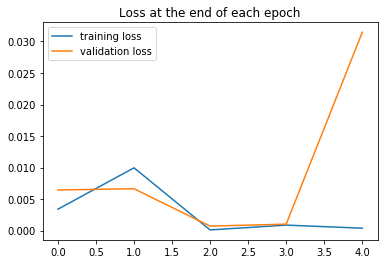

In [25]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

Validation loss increases after 3 epochs means there's overfitting if we training further

## Evaluate Test Data

In [26]:
# Extract the data all at once, not in batches
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

In [27]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)  # we don't flatten the data this time
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')

Test accuracy: 9874/10000 =  98.740%


Recall that our [784,120,84,10] ANN returned an accuracy of 97.25% after 10 epochs. And it used 105,214 parameters to our current 60,074.

## Display the confusion matrix

In [28]:
# print a row of values for reference
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))
print(np.arange(10).reshape(1,10))
print()

# print the confusion matrix
print(confusion_matrix(predicted.view(-1), y_test.view(-1)))

[[   0    1    2    3    4    5    6    7    8    9]]

[[ 978    1    5    1    0    2    7    0   10    0]
 [   0 1130    3    2    0    0    1    5    0    1]
 [   0    0 1015    0    1    0    0    7    0    0]
 [   0    1    1 1004    0    9    0    1    1    2]
 [   0    0    0    0  963    0    1    1    0    1]
 [   0    0    0    0    0  873    2    0    0    2]
 [   2    1    1    0    4    1  944    0    0    0]
 [   0    0    4    1    1    0    0 1005    0    1]
 [   0    2    3    2    2    1    3    1  961    1]
 [   0    0    0    0   11    6    0    8    2 1001]]


## Examine the misses
We can track the index positions of "missed" predictions, and extract the corresponding image and label. We'll do this in batches to save screen space.

In [29]:
misses = np.array([])
for i in range(len(predicted.view(-1))):
    if predicted[i] != y_test[i]:
        misses = np.append(misses,i).astype('int64')
        
# Display the number of misses
len(misses)

126

In [30]:
# Display the first 10 index positions
misses[:10]

array([ 175,  247,  320,  340,  412,  445,  460,  495,  619,  646],
      dtype=int64)

In [31]:
# Set up an iterator to feed batched rows
r = 12   # row size
row = iter(np.array_split(misses,len(misses)//r+1))

Index: [ 175  247  320  340  412  445  460  495  619  646  659  667]
Label: [   7    4    9    5    5    6    5    8    1    2    2    7]
Guess: [   1    2    8    3    3    0    9    0    8    6    1    1]


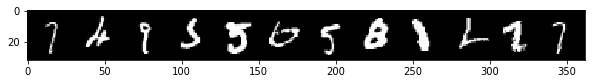

In [32]:
nextrow = next(row)
print("Index:", nextrow)
print("Label:", y_test.index_select(0,torch.tensor(nextrow)).numpy())
print("Guess:", predicted.index_select(0,torch.tensor(nextrow)).numpy())

images = X_test.index_select(0,torch.tensor(nextrow))
im = make_grid(images, nrow=r)
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

## Run a new image through the model
We can also pass a single image through the model to obtain a prediction.
Pick a number from 0 to 9999, assign it to "x", and we'll use that value to select a number from the MNIST test set.

In [34]:
x = 2019  # random

In [36]:
# Contains 28 main arrays, each array with 28 elements
# Thus representing a 28 x 28 pixels of an image
# At the end, it also has the label, which is 9 in this case
test_data[x]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

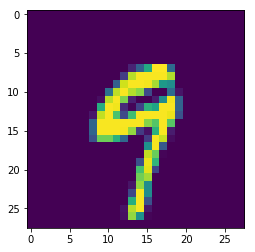

In [39]:
plt.imshow(test_data[x][0].reshape((28,28)));

In [40]:
model.eval()
with torch.no_grad():
    # Remember to reshape your test data with .view(batch_size, no._color_channel, pixel_height, pixel_width)
    # CNN model requires
    new_pred = model(test_data[x][0].view(1,1,28,28)).argmax()
print("Predicted value:",new_pred.item())

Predicted value: 9
